<center><h1>Experiments on SC09 Dataset</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

The dataset is actually just the audio track of [this 4 hour piano video from YouTube](https://www.youtube.com/watch?v=EhO_MrRfftU). It's resampled at 16 kHz and divided into 1 minute WAV files. Thankfully, the authors of the paper have already done this step and uploaded the processed dataset [here on HuggingFace](https://huggingface.co/datasets/krandiash/youtubemix).

In [4]:
train_dataset = SC09("../datasets/sc09/train", device=device)

WAV files in directory: 5965
729 WAV file(s) were discarded because they were not 1 second long.


In [5]:
len(train_dataset)

5236

In [6]:
x, y = train_dataset[0]
assert list(x.size()) == [16000]
assert list(y.size()) == [16000]

`x` contains samples 0 to N in the sound file, each sample is a float between -1 and +1. `y`, on the other hand, contains samples 1 to N+1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

Let's listen to one of the sound files in the dataset:

In [7]:
ipd.Audio(mu_law_decoding(x, 256).cpu().numpy(), rate=16000)

Check whether the labels are encoded correctly using [mu-law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm).

In [8]:
ipd.Audio(mu_law_decoding(y, 256).cpu().numpy(), rate=16000)

# The Model

Here, we define the SaShiMi model with the hyperparameters given in Appendix C.2.1.

In [50]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000,
    block_count=4,
    encoder=Embedding(256, 64),
).to(device)

For "simplicity", they don't train the low-rank term $pp^*$, the $B$ matrix and the timescale $\Delta$. In some of our full dataset experiments, we do the same, but we still train $\Delta$ because they don't provide the initial value for that parameter.

In [51]:
for module in model.modules():
    # isinstance doesn't work due to automatic reloading
    if type(module).__name__ == S4Base.__name__:
        module.B.requires_grad = False
        module.P.requires_grad = False

Let's inspect the number of parameters in our model:

In [52]:
sum([i.nelement() for i in model.parameters()])

2332300

# Training the Model: Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

In [53]:
x, y = train_dataset[0]
overfit_dataset = [(x, y)]

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/500 [00:00<?, ?it/s]

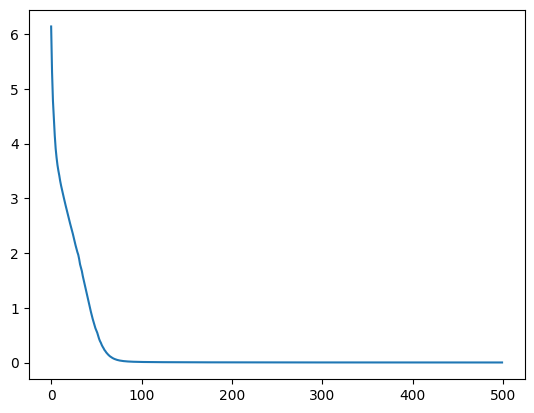

In [55]:
model.train()
for epoch in tqdm(range(500), leave=False):
    train_loss = 0.0
    for x, y in overfit_dataset:
        y_hat = model(x)
        loss = criterion(y_hat.view(-1, 256), y.view(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

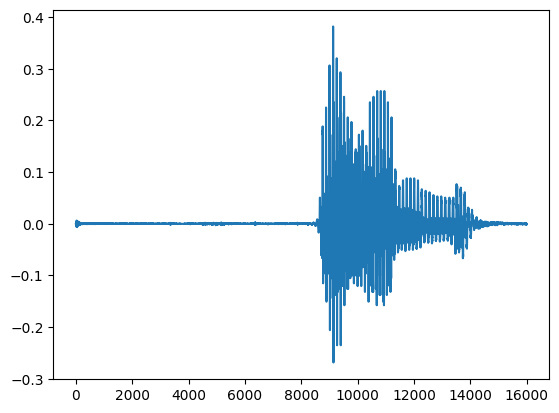

In [56]:
model.eval()
with torch.no_grad():
    train_loss = 0.0
    for x, y in overfit_dataset:
        y_hat = model(x)
        gen = mu_law_decoding(torch.argmax(y_hat, dim=-1), 256.0)
        gen = gen.flatten().cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [57]:
(gen.cuda() - mu_law_decoding(y, 256)).abs().max()

tensor(0., device='cuda:0')

## Sampling

The following method will autoregressively sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

In [58]:
def generate_sample(m, count: int, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(mu_law_encoding(torch.zeros(1, device=device), 256))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in tqdm(range(count - primed_size), leave=False):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        return torch.cat([priming_signal, generated], dim=0)
    else:
        return generated

Let's generate a sample and listen to it:

  0%|          | 0/16000 [00:00<?, ?it/s]

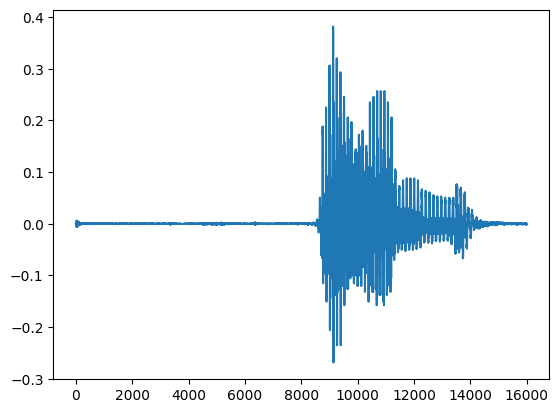

In [59]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

We can also save it as WAV:

In [19]:
import scipy
scipy.io.wavfile.write("overfitting.wav", 16000, gen.flatten().numpy())

# Full Dataset Training

Since training on the full dataset takes a lot of time, we won't demonstrate it in this notebook. The training code is exactly the same as above, except that we use the full dataset instead of `overfit_dataset`.

We have trained several models on the full Youtube Mix dataset. In all of these model, the SaShiMi structure is the same as the model in the previous overfitting test. 

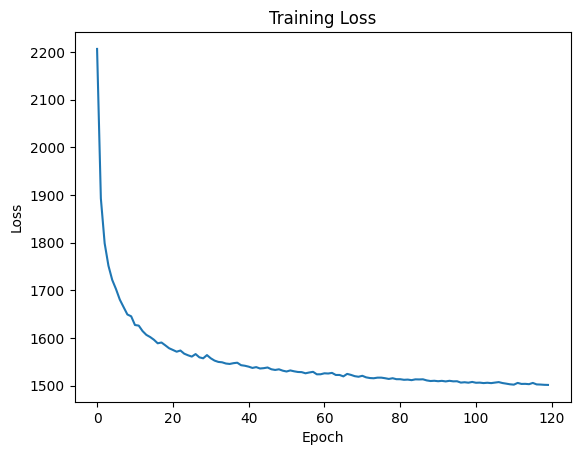

In [16]:
losses = [2206.714503288269, 1892.8376927375793, 1798.7762007713318, 1751.6627019643784, 1721.8187228441238, 1702.5243314504623, 1680.51602435112, 1664.790785908699, 1649.3202385902405, 1645.4681898355484, 1627.2243010997772, 1625.9448934793472, 1614.5389431715012, 1606.5550869703293, 1602.0257893800735, 1596.3073729276657, 1588.844923377037, 1590.4778273105621, 1584.608279824257, 1578.4953309297562, 1574.899953365326, 1571.212173819542, 1573.6603639125824, 1567.0249650478363, 1563.6934441328049, 1560.908671617508, 1566.2066025733948, 1559.3603963851929, 1557.3266056776047, 1564.0621985197067, 1557.362306714058, 1552.5327880382538, 1549.7743414640427, 1548.931901216507, 1546.378544330597, 1545.4771465063095, 1547.1182817220688, 1548.0632297992706, 1542.8742974996567, 1541.7094634771347, 1539.8102731704712, 1537.148298740387, 1538.8227689266205, 1535.9487508535385, 1536.6537154912949, 1538.0517091751099, 1534.3240123987198, 1532.8811935186386, 1534.240694284439, 1531.3742699623108, 1529.6403450965881, 1531.8767582178116, 1530.0391817092896, 1528.6389099359512, 1528.30956864357, 1525.8905007839203, 1527.5754491090775, 1528.927073955536, 1523.7218132019043, 1523.829626083374, 1525.852037191391, 1525.4084479808807, 1526.7131185531616, 1522.3629845380783, 1522.356600522995, 1519.3973525762558, 1524.617091178894, 1522.5218156576157, 1519.8305302858353, 1518.6092456579208, 1520.6161178350449, 1517.3603366613388, 1515.911299586296, 1515.4445906877518, 1516.7203863859177, 1516.747349023819, 1515.5404312610626, 1514.005585551262, 1515.5140676498413, 1513.4860018491745, 1513.4578648805618, 1512.2079638242722, 1512.6401113271713, 1511.488088130951, 1513.150094151497, 1512.957022190094, 1513.256695151329, 1510.9359484910965, 1509.648723602295, 1510.1786807775497, 1509.2439334392548, 1509.9835790395737, 1508.8237920999527, 1510.0954205989838, 1508.976022362709, 1509.1716985702515, 1506.3627383708954, 1507.0818316936493, 1506.137373805046, 1507.733493566513, 1506.004174232483, 1506.2883588075638, 1505.3206142187119, 1506.0131376981735, 1505.250267982483, 1506.3595852851868, 1507.3947532176971, 1505.4000704288483, 1504.1169321537018, 1502.755066037178, 1502.0476957559586, 1505.6723314523697, 1503.5494047403336, 1503.7242586612701, 1503.0410667657852, 1505.6492438316345, 1502.5447710752487, 1502.2507047653198, 1501.6901588439941, 1501.4629670381546]
#plt.figure()
plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)

# Loading a Pre-Trained Model

Let's load the second pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [8]:
model = torch.load("../models/sc09-2/epoch120.pt", map_location=device)

Now, let's sample from this model that has been trained on the full YouTube Mix dataset.

  0%|          | 0/16000 [00:00<?, ?it/s]

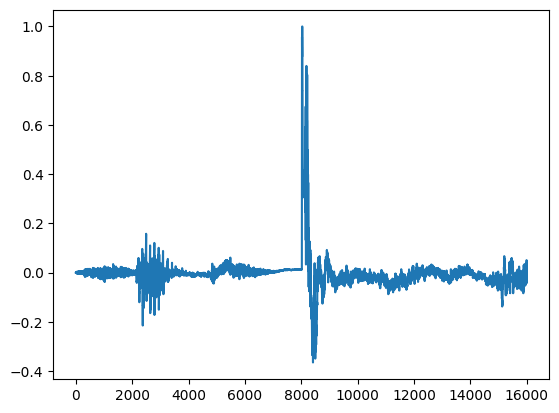

In [48]:
torch.manual_seed(13)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [49]:
import scipy
scipy.io.wavfile.write("outputs/sc09-2/epoch120-seed13.wav", 16000, gen.numpy())

# Reproducing the Results

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the ~test~ validation dataset.

In [41]:
test_dataset = SC09("../datasets/sc09/validation", device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_dataset)

WAV files in directory: 691
85 WAV file(s) were discarded because they were not 1 second long.


606

In [43]:
model.eval()
with torch.no_grad():
    p = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        x = model(x)
        # Apply softmax to get probabilities
        x = torch.nn.functional.softmax(x, dim=-1)
        # Get the probability of correct labels
        x = torch.take(x, y)
        # Get mean
        x = torch.mean(x)
        p += x
    p /= len(test_dataset)

    print("Average probability of correct prediction:", p.item())
    # Convert to NLL in base 2
    print("Average NLL:", (-(p.log()) / torch.tensor(2.0).log()).item())

  0%|          | 0/606 [00:00<?, ?it/s]

Average probability of correct prediction: 0.03771801292896271
Average NLL: 4.728602409362793


In [42]:
model.eval()
with torch.no_grad():
    nll = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        x = model(x)
        # Apply softmax to get log probabilities
        x = torch.nn.functional.log_softmax(x, dim=-1)
        # Get the log probability of correct labels
        x = torch.take(x, y)
        # Get mean
        x = torch.mean(x)
        nll -= x
    nll /= len(test_dataset)

    print("Average probability of correct prediction:", (-nll).exp().item())
    # Convert to NLL in base 2
    print("Average NLL:", (nll / torch.tensor(2.0).log()).item())

  0%|          | 0/606 [00:00<?, ?it/s]

Average probability of correct prediction: 0.005128167569637299
Average NLL: 7.6073408126831055


Quantitative results are as bad as qualitative results.